Ex 3.3: Compositing and reflections. Section 3.1.3 describes the process of compositing
an alpha-matted image on top of another. Answer the following questions and optionally
validate them experimentally:
1. Most captured images have gamma correction applied to them. Does this invalidate the
basic compositing equation (3.8); if so, how should it be fixed?
2. The additive (pure reflection) model may have limitations. What happens if the glass is
tinted, especially to a non-gray hue? How about if the glass is dirty or smudged? How
could you model wavy glass or other kinds of refractive objects?

Compositing is the process of blending an image with another using an alpha matte. The alpha matte controls the transparency of the foreground image, allowing it to be smoothly overlaid onto the background. 

C=αF+(1−α)B

1. 

Yes, it does. The reason is that the compositing equation assumes linear intensity values, but most images we work with have undergone gamma correction.

Since the equation involves weighted sums of pixel intensities, applying it directly on gamma-corrected values leads to incorrect results because addition and multiplication do not behave linearly in gamma space.

To correct this:

1. Convert to Linear Space: Apply the inverse gamma transformation:
    F′=F**γ,B′=B **γ

    where γγ is usually 2.2.

2. Apply the Compositing Equation in Linear Space:
    C′=αF′+(1−α)B′

3. Convert Back to Gamma Space:
    C=(C′)**1/γ


This ensures that compositing is performed correctly and produces visually accurate results.

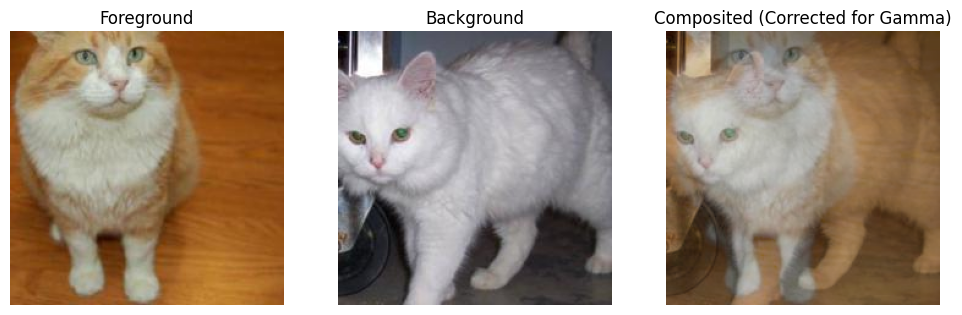

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def apply_gamma_correction(image, gamma=2.2):
    """Convert image to linear space."""
    return np.power(image / 255.0, 1.0 / gamma)

def inverse_gamma_correction(image, gamma=2.2):
    """Convert image back to gamma space."""
    return np.power(image, gamma) * 255.0

def alpha_compositing(foreground, background, alpha, gamma=2.2):
    """Perform correct alpha compositing with gamma correction."""
    
    # Convert images to linear space
    fg_linear = apply_gamma_correction(foreground, gamma)
    bg_linear = apply_gamma_correction(background, gamma)

    # Perform alpha blending in linear space
    composite_linear = alpha * fg_linear + (1 - alpha) * bg_linear

    # Convert back to gamma space
    composite_gamma = inverse_gamma_correction(composite_linear, gamma)
    
    return np.clip(composite_gamma, 0, 255).astype(np.uint8)

# Load images (ensure they are same size)
foreground = cv2.imread('ginger.png')  # Replace with actual image
background = cv2.imread('white.png')

# Convert images to RGB (OpenCV loads in BGR)
foreground = cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB)
background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)

# Create an alpha mask (0.5 transparency for demo)
alpha = np.full(foreground.shape[:2], 0.5, dtype=np.float32)
alpha = np.expand_dims(alpha, axis=-1)  # Convert (224,224) -> (224,224,1)
alpha = np.repeat(alpha, 3, axis=-1)    # Convert (224,224,1) -> (224,224,3)

# Apply alpha compositing with correct gamma correction
composited_image = alpha_compositing(foreground, background, alpha)

# Display results
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(foreground)
plt.title('Foreground')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(background)
plt.title('Background')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(composited_image)
plt.title('Composited (Corrected for Gamma)')
plt.axis('off')

plt.show()


In computer graphics and vision, reflections on surfaces like glass are often modeled using a simple additive model:
I=TB+RR′
I=TB+RR′

Where:

II is the final image.
BB is the background scene behind the glass.
TT is the transmission coefficient (amount of light passing through).
R′R′ is the reflected scene.
RR is the reflection coefficient (amount of light reflected).

This model assumes that glass perfectly transmits and reflects light in an unbiased way.
Limitations

### Tinted Glass
If the glass has a color tint (e.g., blue-tinted glass), it does not uniformly transmit light.
Instead of simple additive blending, the transmitted light TBTB is selectively attenuated based on wavelength.
Correction: Modify the transmission term by a color filter matrix TcTc​:
I=(Tc⋅B)+(RR′)
I=(Tc​⋅B)+(RR′)
This means different color channels are affected non-linearly.

### Dirty or Smudged Glass
A dirty glass diffuses the transmitted and reflected light.
Instead of a sharp reflection, you get blurred reflections.
Correction: Apply a Gaussian blur to the reflected image:
I=TB+RGaussianBlur(R′)
I=TB+RGaussianBlur(R′)

### Wavy Glass or Refractive Distortions
Imperfections in glass (e.g., wavy glass) cause spatial warping due to refraction.
The background BB and reflection R′R′ are spatially displaced in a non-linear way.
Correction: Introduce a spatial distortion function D(x,y)D(x,y) to model the distortions:
I=TB(D(x,y))+RR′(D(x,y))
I=TB(D(x,y))+RR′(D(x,y))
The function D(x,y)D(x,y) models how light bends at different points.

How to Model These Effects in Code?
1. Tinted Glass

Modify the color channels differently to simulate selective attenuation.

### Apply a color tint (e.g., blue glass)
tinted_background = background * np.array([0.8, 0.9, 1.2])  # Reduce Red & Green, increase Blue

2. Dirty or Smudged Glass

Apply a Gaussian blur to the reflection.

reflection_blurred = cv2.GaussianBlur(reflection, (5,5), sigmaX=2)

3. Wavy Glass Distortions

Apply a displacement map to warp the image.

map_x, map_y = np.meshgrid(np.linspace(0, 1, width), np.linspace(0, 1, height))
map_x = map_x + 0.02 * np.sin(10 * map_y)  # Simulate wavy distortion
map_y = map_y + 0.02 * np.sin(10 * map_x)
distorted_image = cv2.remap(background, map_x, map_y, interpolation=cv2.INTER_LINEAR)
